In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Data Processing
## Todo List
1. Calculate running totals and average wins/loses
2. Generate Plots
3. Assign skill scores
4. Create betting metrics/odds
5. Easy data entry mode

In [2]:
df_data = pd.read_csv("data.csv")
guests = ['oscar','nick','drew','ruohan','brandon','ruohan','lixin']
big3 = ['connor','helio','sam']
#Add a guest column
df_data['guest']= df_data[guests].sum(axis=1)
players = big3+guests+['guest']
df = df_data[players].cumsum()
#Convert to Dollars
df = df/100
#df.to_csv("results.csv", index = False)

## Some Basic Plots
We start with the net profit loss chart. 

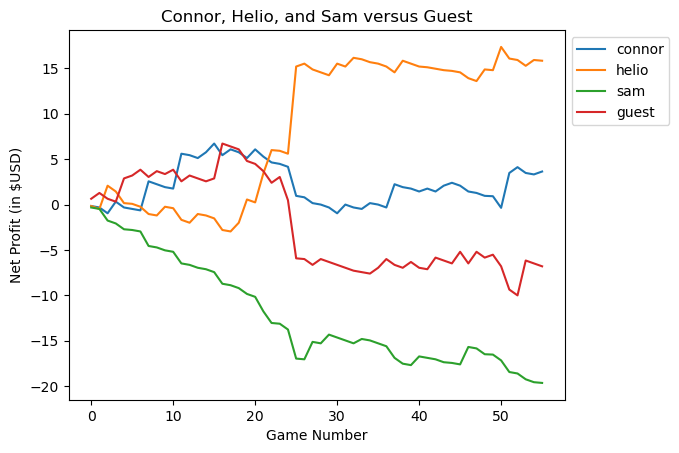

In [3]:
ax1 = df[big3+['guest']].plot()
ax1.set_title('Connor, Helio, and Sam versus Guest')
plt.xlabel("Game Number")
plt.ylabel("Net Profit (in $USD)")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit.png", bbox_inches='tight')


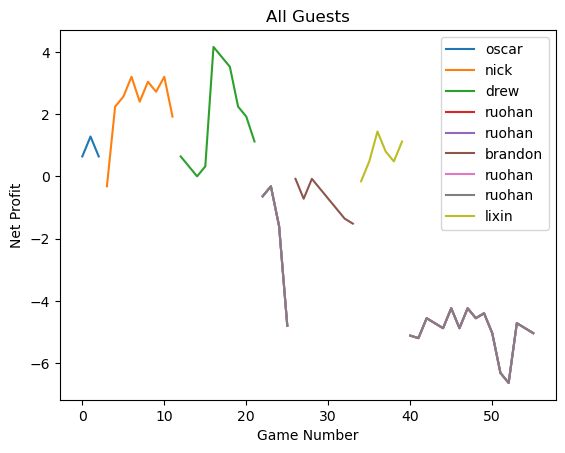

In [4]:

ax2 = df[guests].plot()
ax2.set_title('All Guests')
plt.xlabel("Game Number")
plt.ylabel("Net Profit")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit_guests.png", bbox_inches="tight")


## Autocorrelation Plots
An autocorrelogram shows that there appears to be a self correlation for low amounts of lag. The current theory for this is that this may be picking up the winning advantage of being dealer, and if someone wins while dealer they remain dealer hence giving a *hot hands* effect. 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

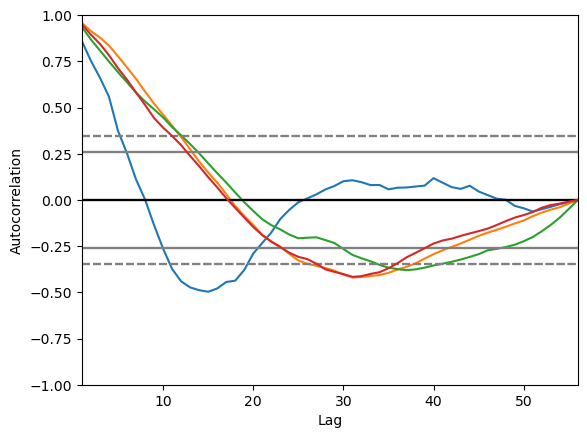

In [5]:
pd.plotting.autocorrelation_plot(df['connor'])
pd.plotting.autocorrelation_plot(df['helio'])
pd.plotting.autocorrelation_plot(df['sam'])
pd.plotting.autocorrelation_plot(df['guest'])

## Trend decomposition
We suspect that a players performance over time is an additive function of some linear trend with noise. We can verify this by taking a trend decomposition of net profit/loss. 

In [6]:
#Convert to Readme